<a href="https://colab.research.google.com/github/shakyaroopal/CyberBully-Detection/blob/main/Cyberbully_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
import networkx as nx
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/cyberbullying_tweets.csv')

In [ ]:
sentences=df.tweet_text
label=df.cyberbullying_type
X_train, X_test, y_train, y_test = train_test_split(sentences, label, test_size=0.90, random_state=42)

In [ ]:
len(X_train)

4769

In [ ]:
sentence_embeddings = model(X_train)

In [ ]:
def cosine_similarity_calc(vec1,vec2):
  sim=np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
  return sim

In [ ]:
m=len(sentence_embeddings)
m

4769

In [ ]:
sim_matrix=np.zeros((m,m))
for i in tqdm(range(m)):
  for j in range(i,m):
    sim_matrix[i][j]=cosine_similarity_calc(sentence_embeddings[i],sentence_embeddings[j])
    sim_matrix[j][i]=sim_matrix[i][j]

100%|██████████| 4769/4769 [1:25:39<00:00,  1.08s/it]


In [ ]:
adjacency_matrix=np.zeros((m,m))
for i in tqdm(range(m)):
  for j in range(m):
    if(sim_matrix[i][j]>0.55):
      adjacency_matrix[i][j]=1
    else:
      adjacency_matrix[i][j]=0

In [ ]:
G=nx.Graph()
for i in range(m):
  G.add_node(i)
for i in tqdm(range(m)):
  for j in range(m):
    if(adjacency_matrix[i][j]==1)&(i!=j):
      G.add_edge(i,j)
G.number_of_edges()

100%|██████████| 4769/4769 [00:45<00:00, 103.80it/s]


74050

In [ ]:
y_train=pd.DataFrame(y_train)

In [ ]:
arr=np.arange(m)
y_train=y_train.set_index(arr)

In [ ]:
arr=G.nodes()

In [ ]:
print(arr)

[   0    1    2 ... 4766 4767 4768]


In [ ]:
labeldict={}
for i in range(m):
  if(y_train['cyberbullying_type'][i]=="not_cyberbullying"):
    labeldict[i]=0
  if(y_train['cyberbullying_type'][i]=="gender"):
    labeldict[i]=1
  if(y_train['cyberbullying_type'][i]=="religion"):
    labeldict[i]=2
  if(y_train['cyberbullying_type'][i]=="other_cyberbullying"):
    labeldict[i]=3
  if(y_train['cyberbullying_type'][i]=="age"):
    labeldict[i]=4
  if(y_train['cyberbullying_type'][i]=="ethnicity"):
    labeldict[i]=5


In [ ]:
nx.draw(G, labels=labeldict,node_size=2)

In [ ]:
color_map=[]
for i in range(m):
  if labeldict[i]==0:
    color_map.append('red')
  if labeldict[i]==1:
    color_map.append('orange')
  if labeldict[i]==2:
    color_map.append('blue')
  if labeldict[i]==3:
    color_map.append('pink')
  if labeldict[i]==4:
    color_map.append('green')
  if labeldict[i]==5:
    color_map.append('yellow')

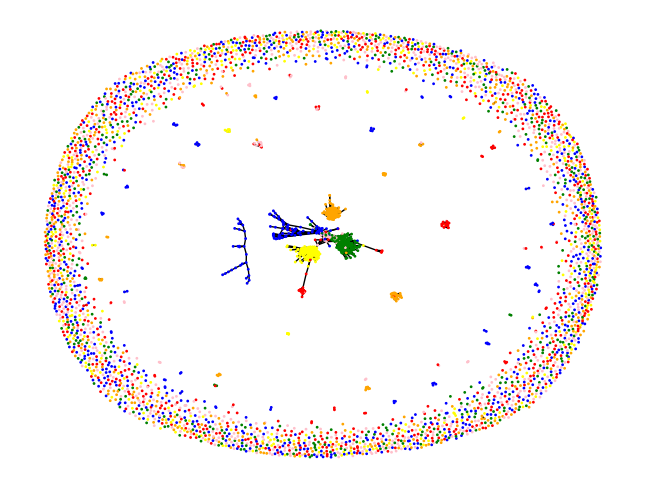

<Figure size 25.6x19.2 with 0 Axes>

In [ ]:
nx.draw(G,node_color=color_map,node_size=1)
plt.figure(3,dpi=4)
plt.show()

In [ ]:
!pip install torch_geometric

In [ ]:
a=list( list(i) for i in list(G.edges()))
edge_index=torch.tensor(a)
edge_idxx=torch.transpose(edge_index,0,1)

In [ ]:
x=np.identity(m,dtype=float)
x=torch.from_numpy(np.asarray(x))
x=x.float()

In [ ]:
target=np.zeros((m))
k=0
for i in arr:
  target[k]=labeldict[i]
  k=k+1
target=torch.from_numpy(np.asarray(target))
target=target.type(torch.long)

In [ ]:
t1=[]
t2=[]
for i in range(m):
  if(i<=3700):
    t1.append(True)
    t2.append(False)
  else:
    t1.append(False)
    t2.append(True)
from sklearn.utils import shuffle
train_mask,test_mask=shuffle(t1,t2,random_state=3)
train_mask=torch.tensor(train_mask)
test_mask=torch.tensor(test_mask)

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(m, 100)
        self.gcn2=GCNConv(100,50)
        self.out = GCNConv(50, 25)
        self.out2 = GCNConv(25, 6)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index)
        h=self.gcn2(h,edge_index)
        z = self.out(h,edge_index)
        z=self.out2(z,edge_index).softmax(dim=1)
        return z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(4769, 100)
  (gcn2): GCNConv(100, 50)
  (out): GCNConv(50, 25)
  (out2): GCNConv(25, 6)
)


In [ ]:
def accuracy(pred_y,y):
  return ((pred_y==y).sum())/len(pred_y)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
target = target.type(torch.LongTensor)
for epoch in range(1000):
    optimizer.zero_grad()
    z = model(x,edge_idxx)
    z=z.float()
    loss = criterion(z[train_mask], target[train_mask])
    acc = accuracy(z.argmax(dim=1)[test_mask],target[test_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.79 | Acc: 16.67%
Epoch  10 | Loss: 1.74 | Acc: 26.03%
Epoch  20 | Loss: 1.65 | Acc: 28.65%
Epoch  30 | Loss: 1.51 | Acc: 34.64%
Epoch  40 | Loss: 1.30 | Acc: 36.89%
Epoch  50 | Loss: 1.13 | Acc: 41.48%
Epoch  60 | Loss: 1.07 | Acc: 44.85%
Epoch  70 | Loss: 1.06 | Acc: 44.76%
Epoch  80 | Loss: 1.06 | Acc: 44.29%
Epoch  90 | Loss: 1.06 | Acc: 43.82%
Epoch 100 | Loss: 1.06 | Acc: 43.45%
Epoch 110 | Loss: 1.05 | Acc: 43.16%
Epoch 120 | Loss: 1.05 | Acc: 42.98%
Epoch 130 | Loss: 1.05 | Acc: 42.88%
Epoch 140 | Loss: 1.05 | Acc: 42.98%
Epoch 150 | Loss: 1.05 | Acc: 42.98%
Epoch 160 | Loss: 1.05 | Acc: 42.88%
Epoch 170 | Loss: 1.05 | Acc: 42.79%
Epoch 180 | Loss: 1.05 | Acc: 42.98%
Epoch 190 | Loss: 1.05 | Acc: 43.26%
Epoch 200 | Loss: 1.05 | Acc: 43.16%
Epoch 210 | Loss: 1.05 | Acc: 43.26%
Epoch 220 | Loss: 1.05 | Acc: 43.26%
Epoch 230 | Loss: 1.05 | Acc: 43.35%
Epoch 240 | Loss: 1.05 | Acc: 43.45%
Epoch 250 | Loss: 1.05 | Acc: 43.54%
Epoch 260 | Loss: 1.05 | Acc: 43.45%
E

In [ ]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    nx.draw_networkx(G,pos=nx.spring_layout(G, seed=0),node_size=2, node_color=color_map,font_size=0)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)